In [1]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataLoader
from toolkit.pytorch_tools import NeuralNetwork
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import Normalize
from torchvision.transforms import ToPILImage
from torchvision.transforms import ToTensor
# from torchvision.transforms import RandomHorizontalFlip
# from torchvision.transforms import RandomVerticalFlip
# from torchvision.transforms import RandomRotation
# from torchvision.transforms import RandomPerspective

from torchsummary import summary

import torch
import gc

In [2]:
torch.cuda.empty_cache()
gc.collect()
logger = Logger("main").get_logger()

In [3]:
data = DataFrameCreator()

samples = ["./data/sd1_sample"]

In [4]:
for sample in samples:
    data.load_dataset(
        sample_dir=sample, labels={"non_defective": 0, "defective": 1}
    )
data.split_dataset()
data.info()
data["dataset"].head()

[    INFO    ] Images loaded from ./data/sd1_sample with label non_defective
[    INFO    ] Images loaded from ./data/sd1_sample with label defective
[    INFO    ] Name :          dataset
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (8733, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          train
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (6289, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          validation
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (1746, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          test
[    INFO    ] Type:           ('dataset',)
[

,img_dir,img_file,img,label,label_enc,type
0,data/sd1_sample/non_defective,img_00000.jpg,data/sd1_sample/non_defective/img_00000.jpg,non_defective,0,dataset
1,data/sd1_sample/non_defective,img_00001.jpg,data/sd1_sample/non_defective/img_00001.jpg,non_defective,0,dataset
2,data/sd1_sample/non_defective,img_00002.jpg,data/sd1_sample/non_defective/img_00002.jpg,non_defective,0,dataset
3,data/sd1_sample/non_defective,img_00003.jpg,data/sd1_sample/non_defective/img_00003.jpg,non_defective,0,dataset
4,data/sd1_sample/non_defective,img_00004.jpg,data/sd1_sample/non_defective/img_00004.jpg,non_defective,0,dataset


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_size = (227, 227)

transform = {
    "train": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "validation": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "test": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
}
target_transform = {
    "train": None,
    "validation": None,
    "test": None,
}

loader = CustomImageDataLoader(
    dataset=data,
    image_col="img",
    label_col="label_enc",
    transform=transform,
    target_transform=target_transform,
)
loader.create_dataloaders(batch_size=8)

[    INFO    ] CustomImageDataSet created
[    INFO    ] Setting dataloader subprocesses to 8
[    INFO    ] Dataloaders created


In [6]:
model = NeuralNetwork(name="VGG19", num_classes=3, input_size=input_size)
model.init_device(device="cpu")
# model.results.create_dashboard(interval=10)
# model.results.dashboard.run_server()

[    INFO    ] Model filename: results/VGG19/20230415_214750.pth
[    INFO    ] Results filename: results/VGG19/20230415_214750.csv
[    INFO    ] Neural Network constructed: VGG19
[    INFO    ] NeuralNetwork(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
summary(model, input_size=(3, *input_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 227, 227]           1,792
              ReLU-2         [-1, 64, 227, 227]               0
            Conv2d-3         [-1, 64, 227, 227]          36,928
              ReLU-4         [-1, 64, 227, 227]               0
         MaxPool2d-5         [-1, 64, 113, 113]               0
            Conv2d-6        [-1, 128, 113, 113]          73,856
              ReLU-7        [-1, 128, 113, 113]               0
            Conv2d-8        [-1, 128, 113, 113]         147,584
              ReLU-9        [-1, 128, 113, 113]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
epochs = 10

model.train_net(epochs=epochs, train_loader=loader["train"], validation_loader=loader["validation"])

[    INFO    ] Model training started
[    INFO    ] Epoch:    0 Loss:  0.3519 Accuracy  1.8626  Validation loss:  0.0292   Validation accuracy:  2.0840
[    INFO    ] Epoch:    1 Loss:  0.2637 Accuracy  2.1358  Validation loss:  0.0287   Validation accuracy:  2.1136
[    INFO    ] Epoch:    2 Loss:  0.2547 Accuracy  2.1932  Validation loss:  0.0286   Validation accuracy:  2.1720
[    INFO    ] Epoch:    3 Loss:  0.2468 Accuracy  2.2626  Validation loss:  0.0285   Validation accuracy:  2.2631
[    INFO    ] Epoch:    4 Loss:  0.2414 Accuracy  2.3514  Validation loss:  0.0284   Validation accuracy:  2.3445
[    INFO    ] Epoch:    5 Loss:  0.2377 Accuracy  2.4157  Validation loss:  0.0284   Validation accuracy:  2.4365
[    INFO    ] Epoch:    6 Loss:  0.2359 Accuracy  2.5043  Validation loss:  0.0283   Validation accuracy:  2.5241
[    INFO    ] Epoch:    7 Loss:  0.2413 Accuracy  2.5952  Validation loss:  0.0285   Validation accuracy:  2.5137
[    INFO    ] Epoch:    8 Loss:  0.2596 A

In [12]:
model.results.data

,loss,accuracy,validation_loss,validation_acc
0,0.351882,1.862632,0.029176,2.084043
1,0.263709,2.135818,0.028729,2.113564
2,0.254671,2.193166,0.028574,2.172043
3,0.246786,2.262589,0.028476,2.263137
4,0.241408,2.351449,0.028426,2.344539
5,0.237692,2.415712,0.028386,2.436509
6,0.235857,2.504267,0.028330,2.524067
7,0.241293,2.595187,0.028472,2.513703
8,0.259594,2.615829,0.028541,2.536150
9,0.241061,2.599427,0.028359,2.729540


In [13]:
model.save_model(epoch=model.results.data.index[-1], loss=model.results.data["loss"].iloc[-1])
model.results.save_data()

[    INFO    ] Model saved to results/AlexNet/20230329_000048.pth
[    INFO    ] Results saved to: results/AlexNet/20230329_000048.csv


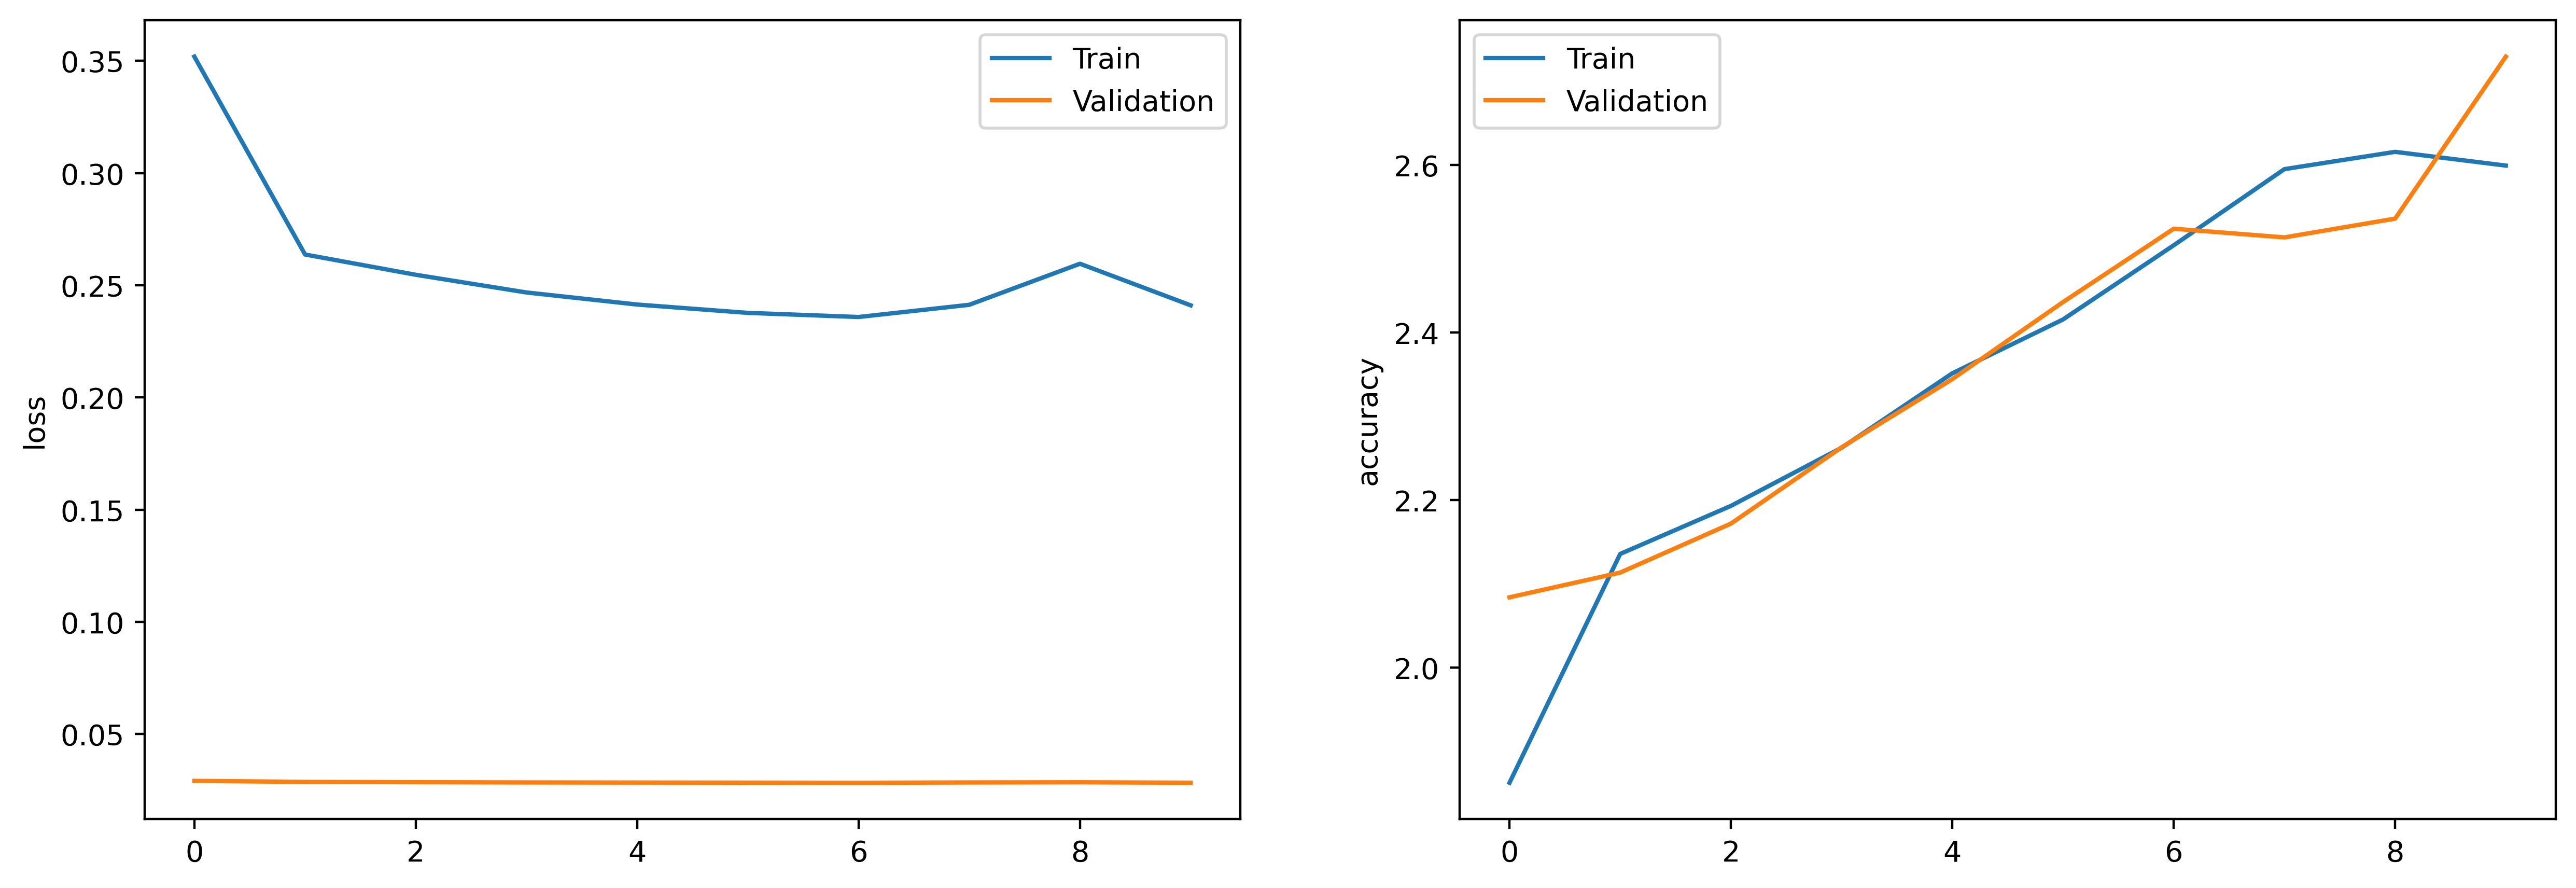

In [14]:
model.results.plot()

In [8]:
model.load_model("./results/AlexNet/20230329_000048.pth")